In [159]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
dtw.try_import_c(verbose=True)
import random as rd
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

All ok ...
== Packages ==
- Numpy version: 1.25.1
- Matplotlib version: 3.7.2
- Scipy version: 1.11.1
== System information ==
namespace(name='cpython', cache_tag='cpython-310', version=sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0), hexversion=50990320, _multiarch='darwin')
== Compilation information ==
Compiler type: unix
--noopenmp: 0
--forceopenmp: 0
--noxpreprocessor: 0
--forcellvm: 0
--forcegnugcc: 0
--forcestatic: 0
Cython found (during compilation)
- Version: 0.29.32
- Locations: <module 'Cython' from '/Users/quentinlao/anaconda3/envs/ml/lib/python3.10/site-packages/Cython/__init__.py'>
Numpy found (during compilation):
- Version: 1.21.6
- Location: <module 'numpy' from '/Users/quentinlao/anaconda3/envs/ml/lib/python3.10/site-packages/numpy/__init__.py'>
Using LLVM settings (x86_64-apple-darwin13.4.0-clang)
Checking for OpenMP availability for x86_64-apple-darwin13.4.0-clang
x86_64-apple-darwin13.4.0-clang -dM -E -Xpreprocessor -fopenmp - # with s

In [160]:
def create_distance_matrix(matrix1, matrix2 = None, Euclidian = False):
    """
    Create distance matrix between matrix1 and matrix2

    If matrix2 is None, then matrix2 = matrix1
    """


    #Convert to dtype=np.double
    matrix1 = np.array(matrix1, dtype=np.double)

    if matrix2 is None : 
        n = matrix1.shape[0]
        distance_matrix = np.zeros((n, n))
        for i in tqdm(range(n),  desc = f"Distance Matrix (Eucl. = {Euclidian})"  ):
            for j in range(i):
                if Euclidian :
                    distance = np.linalg.norm(matrix1[i] - matrix1[j])
                else :
                    distance = dtw.distance_fast(matrix1[i], matrix1[j], window = matrix1.shape[1])
                distance_matrix[i][j] = distance
                distance_matrix[j][i] = distance
    else : 
        matrix2 = np.array(matrix2, dtype=np.double)
        
        n1, n2 = matrix1.shape[0], matrix2.shape[0]
        distance_matrix = np.zeros((n1, n2))
        for i in tqdm(range(n1),  desc = f"Distance Matrix (Eucl. = {Euclidian})" ):
            for j in range(n2):
                if Euclidian :
                    distance_matrix[i][j] = np.linalg.norm(matrix1[i] - matrix2[j])
                else :
                    distance_matrix[i][j] = dtw.distance_fast(matrix1[i], matrix2[j], window = matrix1.shape[1])

    return np.array(distance_matrix)



def initilize_points(matrix, sub_n, alg = "random", Euclidian = False) :
    """
    Return a sub_matrix of matrix with sub_n rows and the rest of matrix
    """
    n = matrix.shape[0]

    if alg == "random" :
        selected_rows = np.random.choice(n, sub_n, replace=False)

    elif alg == "kmeans++" :
        #rd.seed(0)
        selected_rows = np.zeros(sub_n, dtype = np.int64)

        #First center, randomly chosen
        selected_rows[0] = rd.randint(0,n-1)
        
        distance_to_center = np.zeros((n,sub_n - 1), dtype = np.float64)
        distance_to_closest_center = np.zeros(n, dtype = np.float64) #Distance to closest center for each point
        

        for k in tqdm( range(sub_n - 1) ,  desc = "KMEANS++ initialization..." ): #Iterate to determine the remaining n_sub - 1 centers

            #Calculate the distance to the new center k for each point
            if Euclidian : 
                distance_to_center[:,k] = np.linalg.norm(matrix - matrix[selected_rows[k]], axis = 1)
            else :
                for i in range(n):
                    distance_to_center[i,k] = dtw.distance_fast(matrix[i], matrix[selected_rows[k]])

            #Calculate the distance to the closest center for each point
            distance_to_closest_center = np.min(distance_to_center[:,:k+1], axis=1)

            #Calculate the probability of each point to be chosen as a center and choose the new center
            proba = distance_to_closest_center / np.sum(distance_to_closest_center)
            selected_rows[k+1] = np.random.choice(n, p = proba)
        
    
    return np.array([1 if i in selected_rows else 0 for i in range(n)])




def create_new_sample(ref_timeseries, selected_timeseries, paired_timeseries, mode = 1) :
    """
    Create a new sample by modifying the selected_timeseries to make it closer to the paired_timeseries
    """

    if mode == 1 : 
        #For each point x of the paired_timeseries, finds the point y of the selected_timeseries the closest
        d, paths = dtw.warping_paths(selected_timeseries, paired_timeseries, use_c = True)
        best_path_c_p = dtw.best_path(paths)
        closest_index = [[] for i in range(selected_timeseries.shape[0])]
        for a,b in best_path_c_p :
            closest_index[b] += [a]

        newtimeseries = [None]*ref_timeseries.shape[0]
        for i in range(len(newtimeseries)) :
            a = int(np.mean(closest_index[i]))
            newtimeseries[i] = ref_timeseries[a] + paired_timeseries[i] - selected_timeseries[a]

        """
        plt.figure()
        for a,b in best_path_c_p :
            x_values = [a,b]
            y_values = [selected_timeseries[a], paired_timeseries[b]]
            plt.plot(x_values, y_values, linestyle="--", color = (1,0,0,0.3))
        """
    
    elif mode == 2 : 

        #For each point x of the paired_timeseries, finds the point y of the selected_timeseries the closest
        d, paths = dtw.warping_paths(selected_timeseries, paired_timeseries, use_c = True)
        best_path_c_p = dtw.best_path(paths)
        closest_index = [[] for i in range(selected_timeseries.shape[0])]
        for a,b in best_path_c_p :
            closest_index[b] += [a]

        #For each point x of the selected_timeseries, finds the point y of the ref_timeseries the closest
        d, paths = dtw.warping_paths(ref_timeseries, selected_timeseries, use_c = True)
        best_path_r_c = dtw.best_path(paths)
        closest_index_r_c = [[] for i in range(ref_timeseries.shape[0])]
        for a,b in best_path_r_c :
            closest_index_r_c[b] += [a]

        newtimeseries = [None]*ref_timeseries.shape[0]
        for i in range(len(newtimeseries)) :
            a = int(np.mean(closest_index[i]))
            mean_height_of_ref = np.mean( ref_timeseries[closest_index_r_c[a]] )
            newtimeseries[i] = paired_timeseries[i] + (mean_height_of_ref - selected_timeseries[a])

    elif mode == 3 :

        #For each point x of the paired_timeseries, finds the point y of the selected_timeseries the closest
        d, paths = dtw.warping_paths(selected_timeseries, paired_timeseries, use_c = True)
        best_path_c_p = dtw.best_path(paths)
        closest_index = [[] for i in range(selected_timeseries.shape[0])]
        for a,b in best_path_c_p :
            closest_index[b] += [a]

        #For each point x of the selected_timeseries, finds the point y of the ref_timeseries the closest
        d, paths = dtw.warping_paths(ref_timeseries, selected_timeseries, use_c = True)
        best_path_r_c = dtw.best_path(paths)
        closest_index_r_c = [[] for i in range(ref_timeseries.shape[0])]
        for a,b in best_path_r_c :
            closest_index_r_c[b] += [a]

        touched = {i : [] for i in range(paired_timeseries.shape[0])}
        for i in range(paired_timeseries.shape[0]) :
            reachable_cloest_index = closest_index[i]
            for j in reachable_cloest_index :
                reachable_r_cloest_index = closest_index_r_c[j]
                for k in reachable_r_cloest_index :
                    if k + i - j < paired_timeseries.shape[0] and k + i - j >= 0 :
                            touched[k + i - j].append( (i,j,k) )
        
        newtimeseries = [None]*ref_timeseries.shape[0]
        for a in range(len(newtimeseries)) :
            if len(touched[a]) > 0 :
                mean_height_of_ref = np.mean(ref_timeseries[[k for _,_,k in touched[a]]]  + paired_timeseries[[i for i,_,_ in touched[a]]] - selected_timeseries[[j for _,j,_ in touched[a]]])
                newtimeseries[a] = mean_height_of_ref

        #Completes the None with a linear interpolation
        cur = 0
        start_none = None
        while cur < len(newtimeseries) :
            if newtimeseries[cur] is None and start_none is None :
                start_none = cur
            elif newtimeseries[cur] is not None and start_none is not None :
                if start_none == 0 : #If we start with None, we replace them by the first non None value
                    for i in range(start_none, cur) :
                        newtimeseries[i] = newtimeseries[cur] 
                else :
                    for i in range(start_none, cur) : #Else we do a linear interpolation
                        newtimeseries[i] = newtimeseries[start_none-1] + (newtimeseries[cur] - newtimeseries[start_none-1]) * (i - start_none + 1) / (cur - start_none + 1)
                start_none = None
            cur += 1
        if start_none is not None : #If we finish with None, we replace them by the last non None value
            for i in range(start_none, len(newtimeseries)) :
                newtimeseries[i] = newtimeseries[start_none-1]



    return np.array(newtimeseries)

In [161]:
def augment(df, initializer = "random", mode = 1, draw_example = False) :
    """
    Augment the dataset to have the same number of example for each label

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset to augment
    initializer : str
        The method to use to initialize the pairs in the algorithm. Can be "random" or "kmeans++"
    mode : int
        The method to use to augment the dataset. Can be 1, 2 or 3
    draw_example : bool
        If True, draw an example of the augmentation

    Returns
    -------
    pandas.DataFrame
        The augmented dataset
    """

    #Stock the initial number of rows
    initial_number_of_rows = df.shape[0]

    #Get label count and sort it by label
    label_count = df[0].value_counts().to_dict()
    label_count = {label : count for label, count in sorted(label_count.items(), key=lambda item: item[0])}

    #Get the label with maximum count
    label_max = max(label_count, key=label_count.get)

    #If draw, initialize the figure
    if draw_example :
        subplot_number = sum(1 for value in label_count.values() if value < label_count[label_max])
        fig, axs = plt.subplots(subplot_number, figsize=(10, 3*len(label_count)), dpi = 200)
        axis_indice = 0

    for label_to_augment, count_label in label_count.items() :#Iterate over each label to make it have the same count as the label with the maximum count
        
        if label_count[label_to_augment] < label_count[label_max] :

            n_augment = label_count[label_to_augment] #Number of rows to add to the label to augment
            n_ref = label_count[label_max] #Number of rows of the reference label
            

            #### ================================================================== ####
            #### ===== GET THE SUB DATAFRAME TO AUGMENT AND THE REFERENCE ONE ===== ####
            #### ================================================================== ####

            #Sub dataframe with row with the label to augment
            df_augment = df.loc[df[0] == label_to_augment]

            #Sub dataframe with row with the label with the maximum count
            df_ref = df.loc[df[0] == label_max]

            #Drop the first column and convert to numpy array with type double
            matrix_augment = df_augment.drop([0], axis=1).to_numpy(dtype = np.double)
            matrix_ref = df_ref.drop([0], axis=1).to_numpy(dtype = np.double)



            ### ========================================== ###
            ### ====== CREATE PAIRS SELECTED-AUGMENT ===== ###
            ### ========================================== ###

            # Select n_augment rows from matrix_ref
            selected_points = initilize_points(matrix_ref, n_augment, alg = initializer, Euclidian = False)

            #Create distance matrix between the selected points and matrix_augment
            distance_matrix = create_distance_matrix(matrix_ref[selected_points == 1], matrix_augment)

            #For each row in matrix_ref[selected_points == 1], find the row in matrix_augment with the smallest distance
            pairs_selected_augment = {}
            index_selected_points = np.where(selected_points == 1)[0]
            for i in range(n_augment) :
                pairs_selected_augment[index_selected_points[i]] = np.argmin(distance_matrix[i])




            ### ========================================== ###
            ### === CREATE PAIRS SELECTED-NONSELECTED ==== ###
            ### ========================================== ###
            
            #Create distance matrix between the selected points and the rest ones
            distance_matrix = create_distance_matrix(matrix_ref[selected_points == 1], matrix_ref[selected_points == 0], Euclidian = (mode == 1))

            #For each row in matrix_ref[selected_points == 0], find the row in matrix_ref[selected_points == 1] with the smallest distance
            pairs_selected_nonselected = {}
            index_unselected_points = np.where(selected_points == 0)[0]
            for i in range(n_ref - n_augment) :
                pairs_selected_nonselected[index_unselected_points[i]] = index_selected_points[np.argmin(distance_matrix[:,i])]

            assert len(pairs_selected_nonselected) == matrix_ref[selected_points == 0].shape[0]





            ### ========================================== ###
            ### =========== CREATE NEW SAMPLES =========== ###
            ### ========================================== ###

            new_sample = []

            for a,b in tqdm(pairs_selected_nonselected.items(), desc = "Generating new samples") : #For each pair of timeseries, create a new one
                newtimeseries = create_new_sample(matrix_ref[a], matrix_ref[b], matrix_augment[pairs_selected_augment[b]], mode = mode)
                new_sample.append(newtimeseries)

            new_sample = np.array(new_sample)

            #Add the label to augment at the beginning of each row and concatenate the new sample to the original dataframe
            new_sample = np.insert(new_sample, 0, label_to_augment, axis=1)
            new_sample = pd.DataFrame(new_sample, columns=df.columns)
            df = pd.concat([df, new_sample], ignore_index=True)



            ### ========================================== ###
            ### ============= DRAW AN EXAMPLE ============ ###
            ### ========================================== ###

            #Draw an example of each label
            if draw_example :
                a = list(pairs_selected_nonselected.keys())[0]
                b = pairs_selected_nonselected[a]
                newtimeseries = new_sample.iloc[0,1:].to_numpy(dtype = np.double)

                ax = axs if subplot_number == 1 else axs[axis_indice]
    
                ax.plot(matrix_augment[pairs_selected_augment[b]], label="Original timeseries", color = (0,0,1,0.5))
                ax.plot(newtimeseries, label="New timeseries", color = (1,0,0,0.5))

                ax.plot(matrix_ref[a], label="Reference (non selected) timeseries", color = (1,0.5,0,0.5), linestyle = "--", linewidth = 0.5)
                ax.plot(matrix_ref[b], label="Selected timeseries", color = (0,0.5,1,0.5), linestyle = "--", linewidth = 0.5)

                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                ax.set_title(f"Label {label_to_augment}")
                
                axis_indice += 1

    if draw_example : #Draw the figure
        plt.show()

    #Check the balance of the classes
    counts = df[0].value_counts().to_dict()
    first_value = list(counts.values())[0]
    for count in counts.values() :
        assert count == first_value, f"The classes are not balanced : {counts}"

    #Add a column to know which rows are new
    df["new"] = [0 for i in range(initial_number_of_rows)] + [1 for i in range(df.shape[0] - initial_number_of_rows)]

    return df.drop(["new"], axis=1), df
        

Generating new samples: 100%|██████████| 176/176 [00:00<00:00, 1491.82it/s]


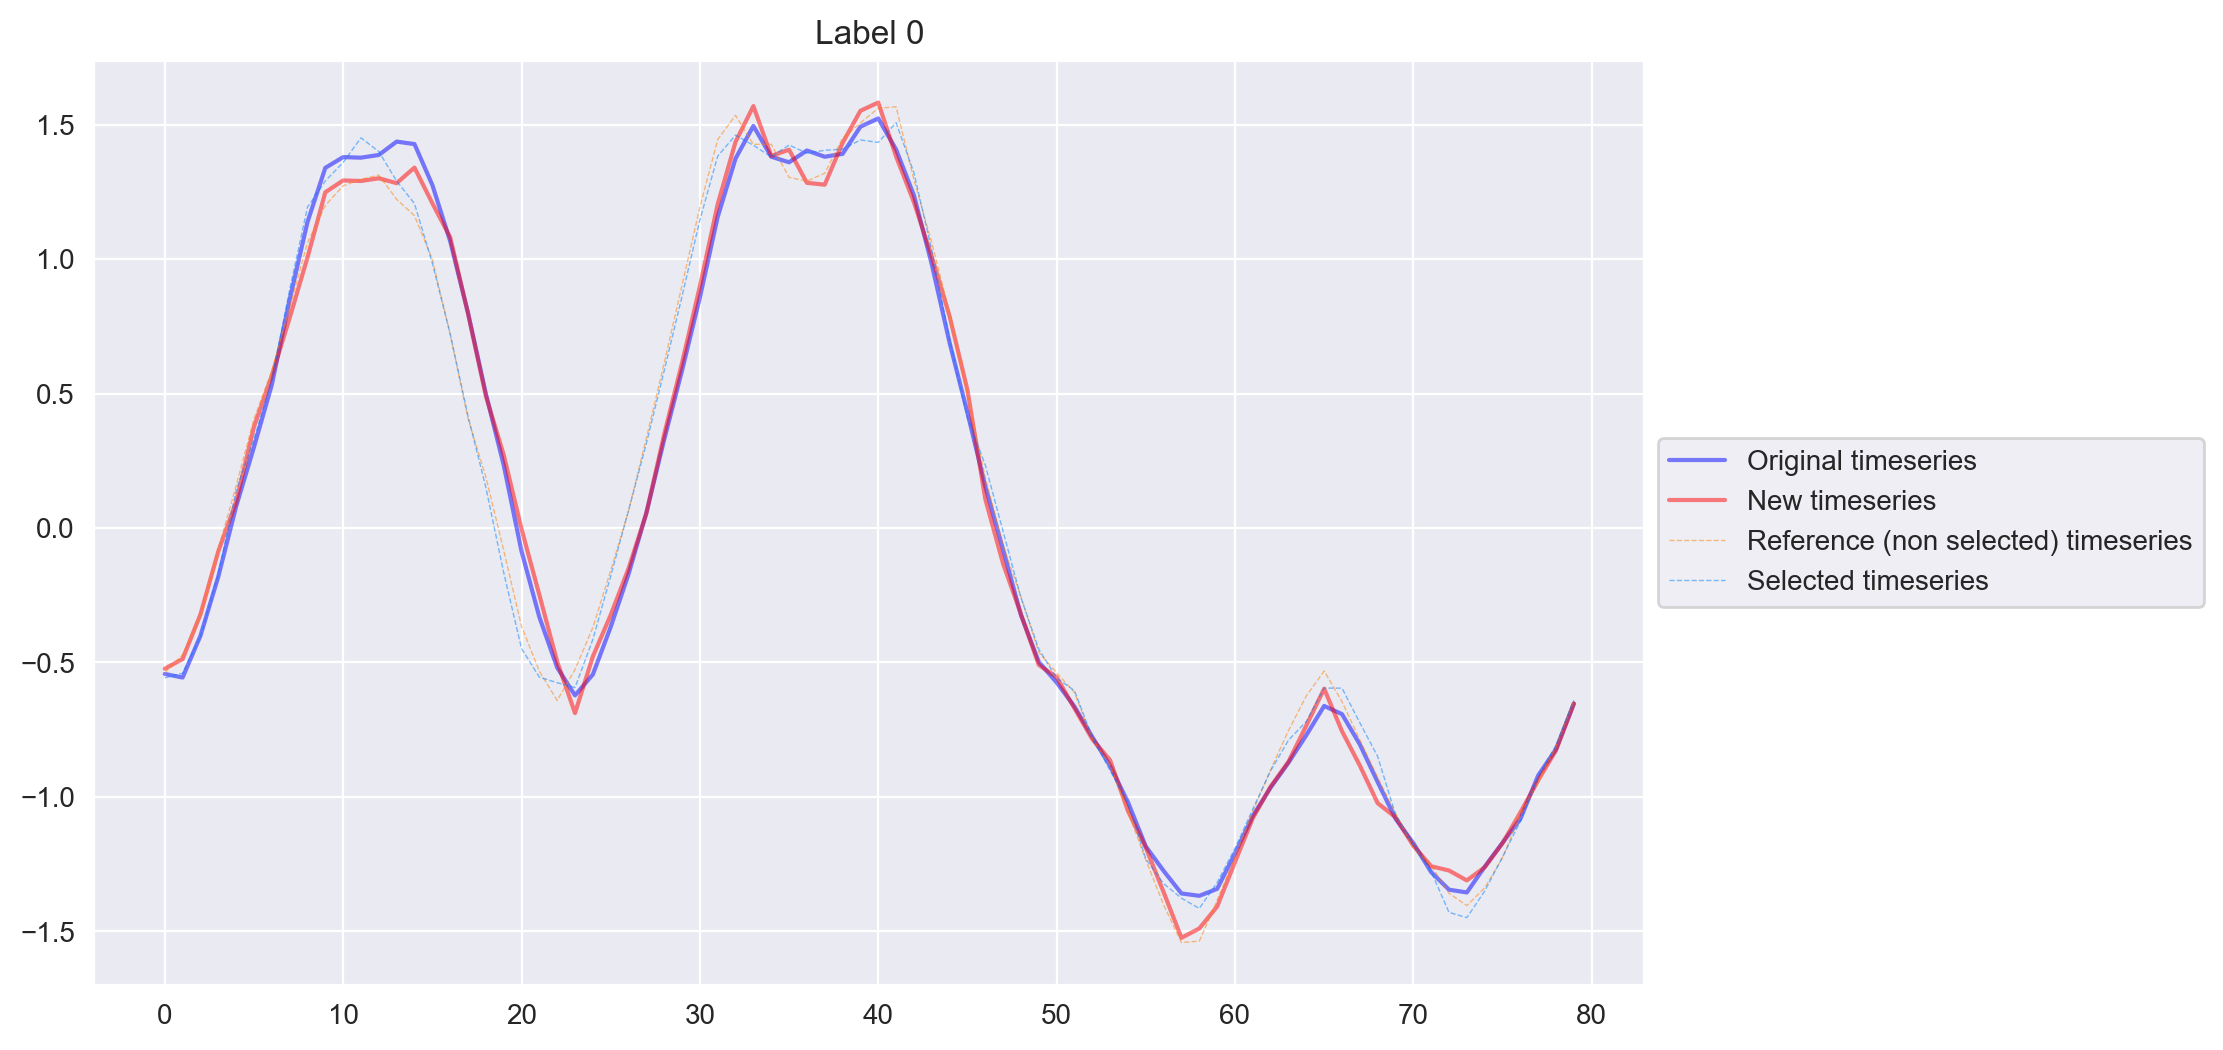

Time elapsed : 5.73 seconds


In [162]:
import time

start = time.time()
df = pd.read_csv('MiddlePhalanxOutlineCorrect_TRAIN.tsv', sep='\t', header = None)
df, df_to_draw = augment(df, initializer = "kmeans++", mode = 1, draw_example = True)
end = time.time()

print(f"Time elapsed : {round(end - start,2)} seconds")

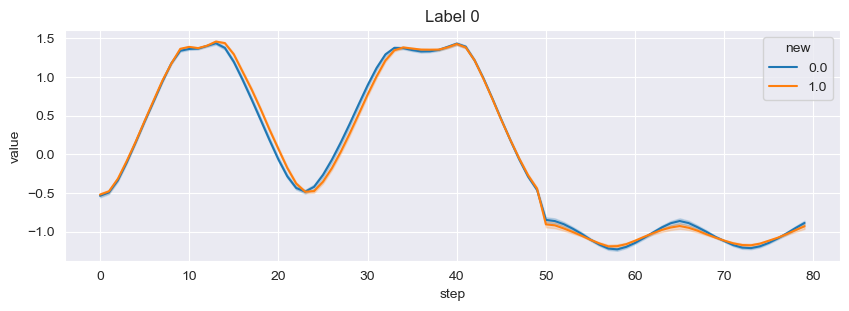

<Figure size 1000x300 with 0 Axes>

In [163]:
## PLOT DOMAINS OF THE LABELS
import seaborn as sns
#Change style of the plots
sns.set_style("darkgrid")

#Get label count and sort it by label
label_count = df_to_draw[0].value_counts().to_dict()
label_count = {label : count for label, count in sorted(label_count.items(), key=lambda item: item[0])}

#Get the label with maximum count
label_max = max(label_count, key=label_count.get)

for label, count in label_count.items() :

    plt.figure(figsize=(10,3))

    #Get the label row in the dataframe
    data = df_to_draw[df_to_draw[0] == label].drop([0], axis=1).to_numpy(dtype = np.double)

    #If the last column is 0 only, then continue (it means that the label is not augmented)
    if np.sum(data[:,-1]) == 0 :
        continue

    length = data.shape[-1] - 1
    draw_df = pd.DataFrame()

    for i in range(length) :
        step_df = pd.DataFrame()
        step_df["new"] = data[:,-1]
        step_df["step"] = i
        step_df["value"] = data[:,i]

        draw_df = pd.concat( [draw_df, step_df], axis = 0)
    
    sns.lineplot(data = draw_df, x="step", y="value", hue = "new")
    plt.title(f"Label {int(label)}")
    plt.show()
    plt.close()


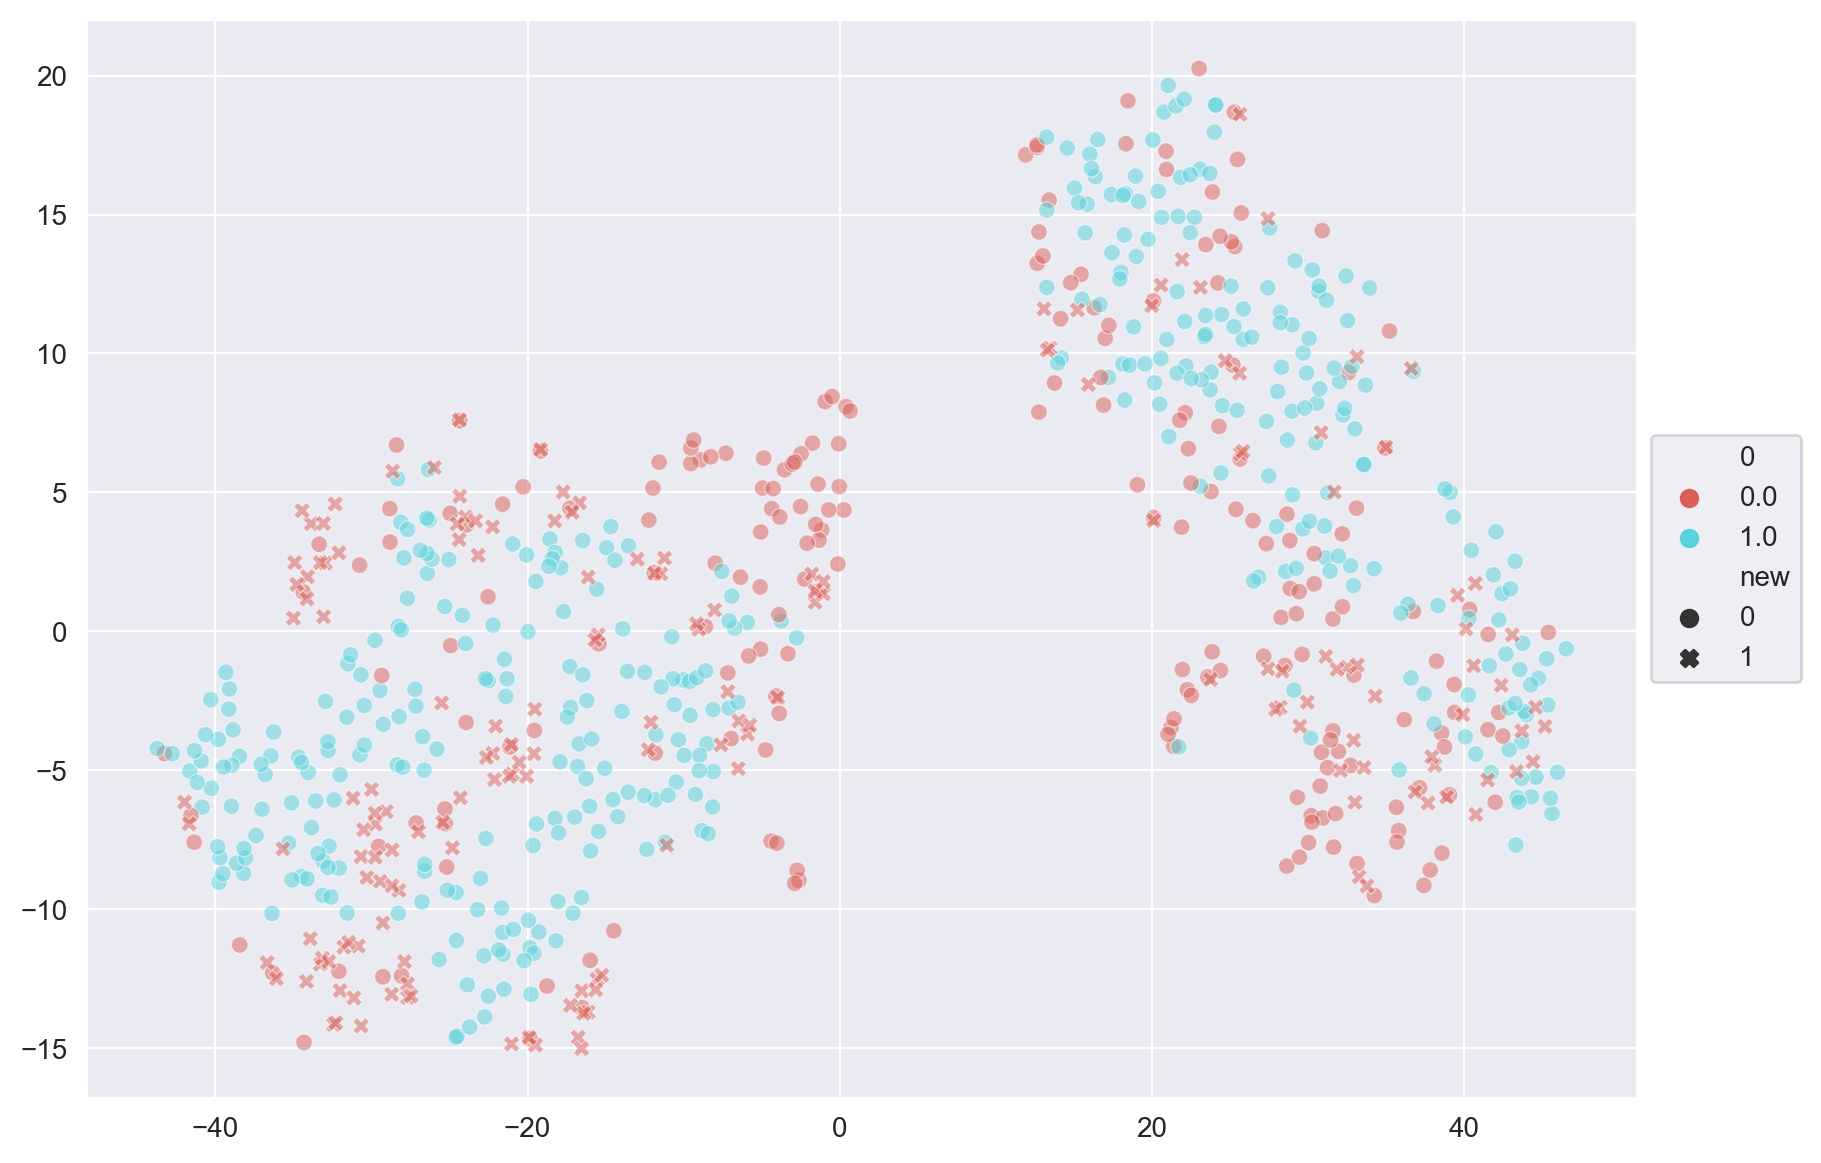

In [164]:
from sklearn.manifold import TSNE

def plot_TSNE(df) :
    """
        new_data : DataFrame
        method : str

        Save the TSNE plot and the synthesized data
    """

    ### PLOT TSNE ###
    plt.figure(figsize=(10, 7), dpi = 200)

    nb_data = len(df)

    unique_labels = df_to_draw[0].unique()

    tsne = TSNE(n_components = 2, perplexity = min(nb_data//20, 40))
    data_transformed = tsne.fit_transform(df.drop([0, "new"], axis = 1))
    colours = sns.color_palette("hls", len(unique_labels))
    sns.scatterplot(x=data_transformed[:,0], y=data_transformed[:,1], hue = df[0], style = df["new"], legend='full', palette=colours, alpha = 0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

plot_TSNE(df_to_draw)